<h1>A/B Testing</h1>

<p><b>Description: </b>a company recently introduced a new bidding type called “average bidding", as an alternative to its existing bidding type, called “maximum bidding”. <br />

<b>Duration of the test: </b>the A/B test has run for 1 month.<br />

<b>Objective: </b>one of our clients, we call them "SUN INC.", has decided to test this new feature and wants to conduct an A/B test to understand if "average bidding" brings more conversions than "maximum bidding".<br />

<b>Source of the file: </b>Kaggle.com<br />

<b>Link: </b>https://www.kaggle.com/ilkeryildiz/example-dataset-for-ab-test?select=control_group.csv<br />

<b>Info about file(s): </b><br />
file one name: control_group.csv<br />
file two name: test_group.csv <br />
size of file one: 3 kB<br />
size of file two: 3 kB<br />
first and second files have: 10 columns<br />
</p>

In [1]:
# improt libaries
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_columns", None)

<h3>Wrangling</h3>

In [2]:
# loading files
path_1 = './data/raw/categ_small_size/control_group.csv'
path_2 = './data/raw/categ_small_size/test_group.csv'

df_1 = pd.read_csv(path_1)
df_2 = pd.read_csv(path_2)

In [3]:
# combining files into one DataFrame
df = df_1.append(df_2, ignore_index=True)
df.head(5)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,8-1-2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,8-2-2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,8-3-2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,8/4/2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,8-5-2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# getting summary stat
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   Reach                59 non-null     float64
 5   # of Website Clicks  59 non-null     float64
 6   # of Searches        59 non-null     float64
 7   # of View Content    59 non-null     float64
 8   # of Add to Cart     59 non-null     float64
 9   # of Purchase        59 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.8+ KB


In [5]:
# renaming columns
df.rename(columns={'Campaign Name': 'group',
           'Date': 'date',
          'Spend [USD]' : 'spend',
          '# of Impressions': 'num_of_impressions',
          'Reach': 'reach',
          '# of Website Clicks': 'num_of_cliks',
          '# of Searches': 'num_of_searches',
          '# of View Content': 'num_of_view_content',
          '# of Add to Cart': 'num_of_add_to_cart',
          '# of Purchase': 'num_of_purchase'}, inplace=True)


df.head(3)

,group,date,spend,num_of_impressions,reach,num_of_cliks,num_of_searches,num_of_view_content,num_of_add_to_cart,num_of_purchase
0,Control Campaign,8-1-2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,8-2-2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,8-3-2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0


In [6]:
# converting into datetime
df['date'] = pd.to_datetime(df['date'])
df.dtypes

group                          object
date                   datetime64[ns]
spend                           int64
num_of_impressions            float64
reach                         float64
num_of_cliks                  float64
num_of_searches               float64
num_of_view_content           float64
num_of_add_to_cart            float64
num_of_purchase               float64
dtype: object

In [7]:
# checking missing values
df.isnull().sum()

group                  0
date                   0
spend                  0
num_of_impressions     1
reach                  1
num_of_cliks           1
num_of_searches        1
num_of_view_content    1
num_of_add_to_cart     1
num_of_purchase        1
dtype: int64

In [8]:
# checking out for that row that has missing values
df[df['reach'].isnull()]

,group,date,spend,num_of_impressions,reach,num_of_cliks,num_of_searches,num_of_view_content,num_of_add_to_cart,num_of_purchase
4,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Note: </b> as we can see due to some technical or human issues we have an incomplete row (with missing values). We won't be dropping this row due to the size of our sample (too small). But we will be keeping eye on it during our statistical analysis.

In [9]:
# checking for duplicates
print(f"# of duplicated rows: {sum(df.duplicated())}")

# of duplicated rows: 0


In [10]:
# converting group values
df['group'] = df['group'].apply(lambda x: 'control' if x == 'Control Campaign' else 'test')
df['group'].unique()

array(['control', 'test'], dtype=object)

In [11]:
# number of observations in two groups
print(f"Group A 'control' has: {len(df[df['group'] == 'control'])} observations")
print(f"Group B 'test' has: {len(df[df['group'] == 'test'])} observations")

Group A 'control' has: 30 observations
Group B 'test' has: 30 observations


<h3>EDA / Stat Analysis</h3>

In [12]:
df.columns

Index(['group', 'date', 'spend', 'num_of_impressions', 'reach', 'num_of_cliks',
       'num_of_searches', 'num_of_view_content', 'num_of_add_to_cart',
       'num_of_purchase'],
      dtype='object')

In [13]:
# grouping by 'group' column
def get_stat_summary_group_by(data, group_by_col):
    for i in data.columns:
        if i in ['group', 'date']:
            pass
        else:
            print(f"Group by {i.upper()}...")
            print(data.groupby(group_by_col)[i].agg(['min', 'max', 'mean', 'std', 'count', 'sum']), '\n')
            print("__________________________________________________________")
        
    return None

In [14]:
get_stat_summary_group_by(df, 'group')

Group by SPEND...
          min   max         mean         std  count    sum
group                                                     
control  1757  3083  2288.433333  367.334451     30  68653
test     1968  3112  2563.066667  348.687681     30  76892 

__________________________________________________________
Group by NUM_OF_IMPRESSIONS...
             min       max           mean           std  count        sum
group                                                                    
control  71274.0  145248.0  109559.758621  21688.922908     29  3177233.0
test     22521.0  133771.0   74584.800000  32121.377422     30  2237544.0 

__________________________________________________________
Group by REACH...
             min       max          mean           std  count        sum
group                                                                   
control  42859.0  127852.0  88844.931034  21832.349595     29  2576503.0
test     10598.0  109834.0  53491.566667  28795.775752     3

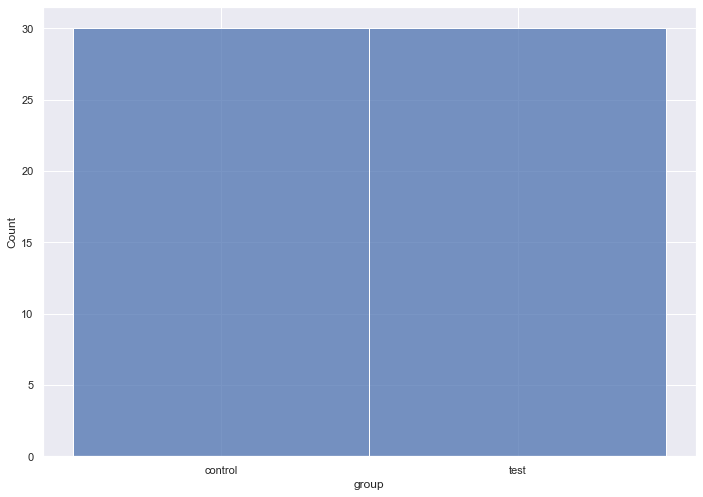

In [15]:
# looking at balance of two groups
_ = sns.histplot(data=df, x='group')

<b>Note: </b>we have two group of equal sizes

In [16]:
# show hist plot of two groups for 'spend' column
def get_hist_plot(data, col_names):
    for i in col_names:
        _ = sns.histplot(data=df[df['group'] == i], x='spend', kde=True, bins=12)
        plt.title(f"HISTPLOT - '{i.upper()}' group")
        plt.show()
        
    return None

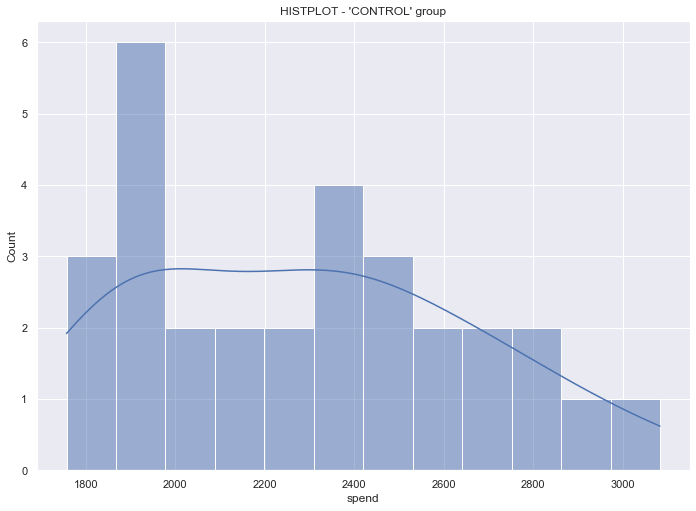

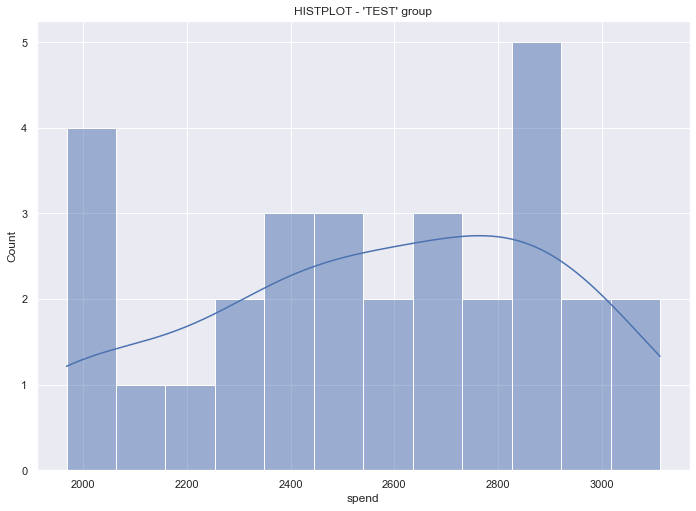

In [17]:
get_hist_plot(df, ['control', 'test'])

<b>Note: </b>from the plot above we can see that mean of group_B is slightly shifted to the right (in other words it's bigger than in group_A).

In [18]:
# show box plot of two groups for 'spend' column
def get_box_plot(data, col_names):
    for i in col_names:
        _ = sns.boxplot(x=df[df['group'] == i]['spend'])
        plt.title(f"BOXPLOT - '{i.upper()}' group")
        plt.show()
        
    return None

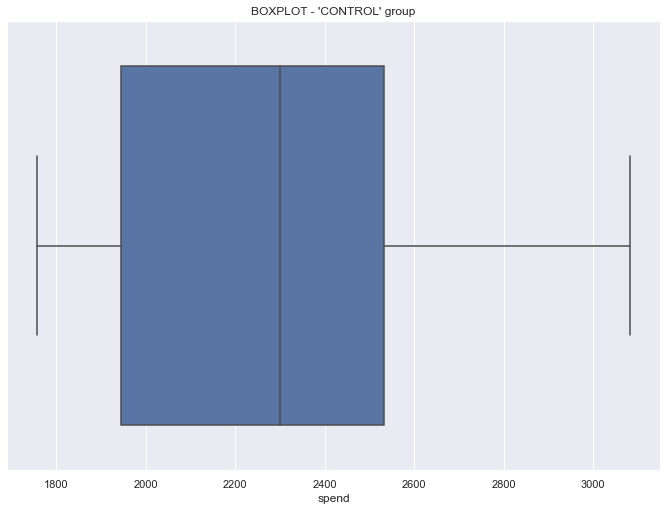

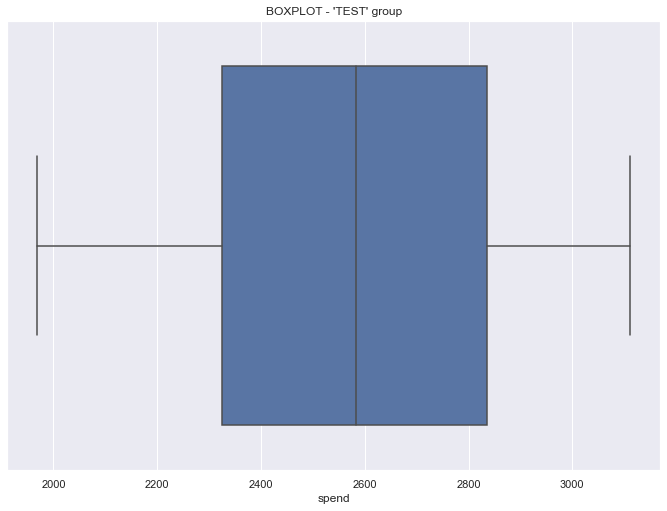

In [19]:
get_box_plot(df, ['control', 'test'])

<b>Note: </b>from the plots above we can see that group_A and group_B does not have outliers.

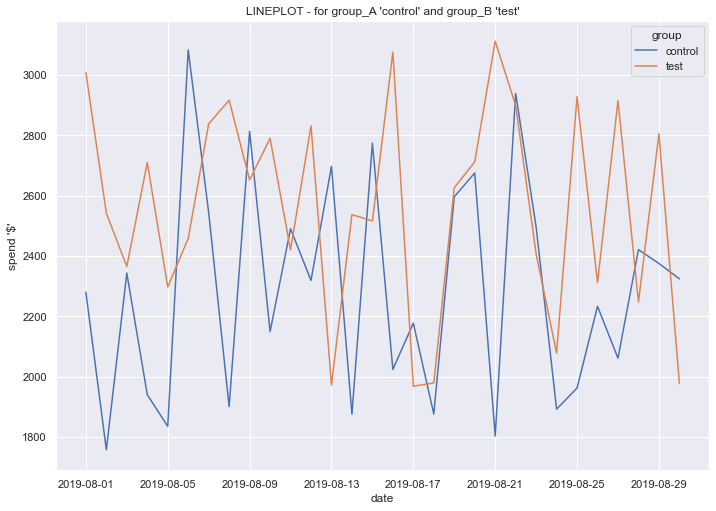

In [20]:
_ = sns.lineplot(data=df, x='date', y='spend', hue='group', err_style="bars")
_ = plt.title(f"LINEPLOT - for group_A 'control' and group_B 'test'")
_ = plt.ylabel("spend '$'")

<b>Note: </b>from the line plot above we can see that group_B (test) has more monthly spending than group_B has.

<h3>A/B Testing</h3>

![A/B - Testing](./imgs/3.png "A/B Testing")

<b>Note: </b>we should mention that we are working with the continuous target variable 'spend'. 
So, our step here is to begin by checking the Normality and Homogeneity of our data. Once we have done with those tests we will know the way how we will be testing our hypothesis (Parametric or Not-Parametric). We also need to remind ourselves that we have a small size of our datasets.

In [21]:
# splitting our data into group_A (control) and group_B (test)
group_A = df[df['group'] == 'control']['spend']
group_B = df[df['group'] == 'test']['spend']

In [22]:
# checking for normality using the Shapiro-Wilk test as our first assumption
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
def check_for_normality(data_list, group_name):
    for index, i in enumerate(data_list):
        shap_stat_result, p_value = shapiro(i)
        
        if p_value <= 0.05:
            print(f"{group_name[index].upper()}")
            print(f"P-value: {round(p_value, 5)}")
            print(f"We REJECT the null hypothesis that the data was drawn from a normal distribution\n")
        else:
            print(f"{group_name[index].upper()}")
            print(f"P-value: {round(p_value, 5)}")
            print(f"We FAILED to reject the null hypothesis that the data was drawn from a normal distribution\n")   
    
    return None

In [23]:
check_for_normality([group_A, group_B], ['group_A', 'group_B'])

GROUP_A
P-value: 0.23127
We FAILED to reject the null hypothesis that the data was drawn from a normal distribution

GROUP_B
P-value: 0.11715
We FAILED to reject the null hypothesis that the data was drawn from a normal distribution



<b>Note: </b>as we can see both our samples have Normality. Now, we will be checking for the second assumption of 'Homogeneity of variance'.

In [24]:
# checking for Homogeneity
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
def check_for_homogeneity(data_list):
    levene_stat_result, p_value = levene(data_list[0], data_list[1])

    if p_value <= 0.05:
        print(f"P-value: {round(p_value, 5)}")
        print(f"We REJECT the null hypothesis that all input samples are from populations with equal variances.\n")
    else:
        print(f"P-value: {round(p_value, 5)}")
        print(f"We FAILED to reject the null hypothesis that all input samples are from populations with equal variances.\n")
        
    return None

In [25]:
check_for_homogeneity([group_A, group_B])

P-value: 0.79842
We FAILED to reject the null hypothesis that all input samples are from populations with equal variances.



<b>Note: </b>we passed the second test for Homogeneity of our samples. So, to test our final hypothesis we will be using Parametric Test.

In [26]:
# calculate the T-test for the means of two independent samples of scores
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
def check_for_ttest_int_for_homogeneity(data_list):
    ttest_ind_stat_result, p_value = ttest_ind(group_A, group_B, equal_var=True)

    if p_value <= 0.05:
        print(f"P-value: {round(p_value, 5)}")
        print(f"We REJECT the null hypothesis that 2 independent samples have identical average (expected) values.\n")
    else:
        print(f"P-value: {round(p_value, 5)}")
        print(f"We FAILED to reject the null hypothesis that 2 independent samples have identical average (expected) values.\n")
        
    return None

In [27]:
check_for_ttest_int_for_homogeneity([group_A, group_B])

P-value: 0.00433
We REJECT the null hypothesis that 2 independent samples have identical average (expected) values.



In [28]:
# looking at average of two groups
df.groupby('group')['spend'].agg(['mean', 'std', 'count', 'sum'])

,mean,std,count,sum
group,,,,
control,2288.433333,367.334451,30,68653
test,2563.066667,348.687681,30,76892


<h3>Conclusion:  </h3>Based on the received results we can state that there is a statistical significance (difference) among the two groups (control and test). <br />
<b>Suggestions: </b>applying a new feature of 'average bidding' increases the monthly revenue compare to ''maximum bidding'.<br />
<b>Further considerations: </b>the experiment time could be extended for at least a few months for better results and further statistical analysis.<br />